In [1]:
import numpy as np
import pickle

import os
import os.path as path

import keras
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import pandas as pd

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

Using TensorFlow backend.


### Loading the preprocessed data and labels

In [2]:
"""
Loading the preprocessed data
"""

train_images = pickle.load( open('train_images32_final.pkl', 'rb'))
train_labels = pickle.load( open('train_labels32_final.pkl', 'rb'))

test_images = pickle.load( open('test_images32_final.pkl', 'rb'))
test_labels = pickle.load( open('test_labels32_final.pkl', 'rb'))


In [3]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D as Convolution2D
from keras.layers import MaxPooling2D, ZeroPadding2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam

### Defining the hyperparameters
    These have been obtained experimentally

In [24]:
MODEL_NAME = 'gtsrb_convnet'
EPOCHS = 20
BATCH_SIZE = 1024
KEEP_PROB = 0.8
LEARNING_RATE = 0.003

### Defining the architecture of the basic model 

In [15]:
"""
Basic model
"""

def Basic_model(weights_path=None):
    model = Sequential()
    model.add(Flatten(input_shape=(32,32,1)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(43, activation='softmax'))
    
    if weights_path:
        model.load_weights(weights_path)

    return model

basic_model = Basic_model()

### Initializing the optimizer for the model

In [16]:
basic_model.compile(optimizer='Adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

### Training the model

In [17]:
trained_model = basic_model.fit(train_images, train_labels, epochs=50, batch_size=BATCH_SIZE, validation_split=0.1, shuffle=True)

Train on 35288 samples, validate on 3921 samples
Epoch 1/50
35288/35288 [==============================] - 1s 38us/step - loss: 1.8337 - acc: 0.5128 - val_loss: 0.8388 - val_acc: 0.7656
Epoch 2/50
35288/35288 [==============================] - 1s 20us/step - loss: 0.6436 - acc: 0.8204 - val_loss: 0.5297 - val_acc: 0.8317
Epoch 3/50
35288/35288 [==============================] - 1s 20us/step - loss: 0.4480 - acc: 0.8798 - val_loss: 0.3537 - val_acc: 0.9074
Epoch 4/50
35288/35288 [==============================] - 1s 20us/step - loss: 0.4275 - acc: 0.8857 - val_loss: 0.3983 - val_acc: 0.8972
Epoch 5/50
35288/35288 [==============================] - 1s 20us/step - loss: 0.2744 - acc: 0.9286 - val_loss: 0.2093 - val_acc: 0.9449
Epoch 6/50
35288/35288 [==============================] - 1s 20us/step - loss: 0.1763 - acc: 0.9517 - val_loss: 0.2932 - val_acc: 0.9186
Epoch 7/50
35288/35288 [==============================] - 1s 20us/step - loss: 0.2221 - acc: 0.9406 - val_loss: 0.2291 - val_acc:

### Measuring the performance of the basic model
    The first value gives the loss and the second value is the accuracy of the model on the training data

In [18]:
"""
model performance evaluation
"""

basic_model.evaluate( test_images, test_labels, batch_size=1024, verbose=1)

12630/12630 [==============================] - 0s 10us/step


[0.80192665466692181, 0.87973080056108188]

### Defining the architecture of the final model 

In [25]:
"""
The model implemented here is a modification of VGGNet 16 which was a winner at ImageNet Challenge
It consists of 3x3 convolutions, Max Poolings, 2 Fully connected layers and dropout.
"""

def VGG_modded(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(32,32,1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))    # 32 x 32

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))   # 16 x 16

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(KEEP_PROB))
    model.add(Dense(43, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

model = VGG_modded()


### Initializing the optimizer for the model

In [26]:
"""
Setting evaluation metrics, optimizer and loss function.
"""

adam = Adam(lr = LEARNING_RATE)

model.compile(optimizer=adam,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

### Training the model

In [27]:
"""
Training the model
"""
trained_model = model.fit(train_images, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, shuffle=True)

Train on 35288 samples, validate on 3921 samples
Epoch 1/20
35288/35288 [==============================] - 10s 272us/step - loss: 2.4070 - acc: 0.3641 - val_loss: 0.5208 - val_acc: 0.8720
Epoch 2/20
35288/35288 [==============================] - 9s 247us/step - loss: 0.5246 - acc: 0.8434 - val_loss: 0.1026 - val_acc: 0.9768
Epoch 3/20
35288/35288 [==============================] - 9s 247us/step - loss: 0.2433 - acc: 0.9286 - val_loss: 0.0623 - val_acc: 0.9855
Epoch 4/20
35288/35288 [==============================] - 9s 247us/step - loss: 0.1550 - acc: 0.9540 - val_loss: 0.0351 - val_acc: 0.9916
Epoch 5/20
35288/35288 [==============================] - 9s 247us/step - loss: 0.1204 - acc: 0.9633 - val_loss: 0.0253 - val_acc: 0.9944
Epoch 6/20
35288/35288 [==============================] - 9s 247us/step - loss: 0.0987 - acc: 0.9703 - val_loss: 0.0249 - val_acc: 0.9946
Epoch 7/20
35288/35288 [==============================] - 9s 247us/step - loss: 0.0817 - acc: 0.9751 - val_loss: 0.0185 - 

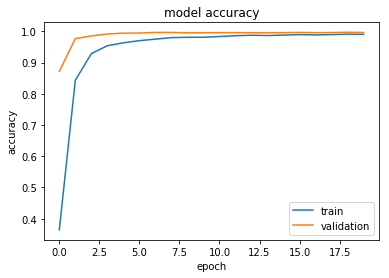

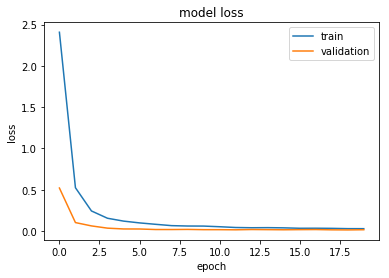

In [32]:
import matplotlib.pyplot as plt 

plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Model performance evaluation
    The first value gives the loss and the second value is the accuracy of the model on the training data

In [20]:
"""
model performance evaluation
"""

model.evaluate( test_images, test_labels, batch_size=1024, verbose=1) #keep_prob 0.8

12630/12630 [==============================] - 1s 85us/step


[0.099006042174658693, 0.97664291228175826]

#### Stratified K-Fold Cross Validation

In [7]:
seed = 29
val_splits = 10    # Number of splits to be made (K)
np.random.seed(seed)   

d = {'Fold' : [], 'Accuracy' : []}
df = pd.DataFrame(d)

kfold = StratifiedKFold(n_splits=val_splits, shuffle=True, random_state=seed)    # Used to generate folds
kscores = []

#merge datasets
f_images = np.append(train_images, test_images, axis = 0)
f_labels = np.append(train_labels, test_labels, axis = 0)
lb = np.argmax(f_labels, axis = 1)

for train, test in kfold.split(f_images,lb):
    model = VGG_modded()
    adam = Adam(lr = LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(f_images[train], f_labels[train], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    scores = model.evaluate(f_images[test], f_labels[test], verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    kscores.append(scores[1] * 100)
    



acc: 99.59%
acc: 99.79%
acc: 99.63%
acc: 99.59%
acc: 99.54%
acc: 99.63%
acc: 99.79%
acc: 99.79%
acc: 99.73%
acc: 99.52%


In [10]:
for i in range(val_splits):
    df.loc[i] = [i+1, kscores[i]]
df.loc[val_splits] = ["mean", np.mean(kscores)]
df.loc[val_splits+1] = ["stddev", np.std(kscores)]
print(df)

             Accuracy
0        1  99.594907
1        2  99.787809
2        3  99.633488
3        4  99.594907
4        5  99.537037
5        6  99.633488
6        7  99.787809
7        8  99.787809
8        9  99.729938
9       10  99.517654
10    mean  99.660485
11  stddev   0.099577


In [7]:
df.head(12).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
Fold,1,2,3,4,5,6,7,8,9,10,mean,stddev
Accuracy,99.5949,99.7878,99.6335,99.5949,99.537,99.6335,99.7878,99.7878,99.7299,99.5177,99.6605,0.0995773


### Function to freeze, optimize and save the tensorflow graph which is to be used on the mobile device

In [22]:
"""
Exporting model for use on android device.
The model is first frozen to prevent further changes in weights
and then optimized for better mobile performance.
"""

def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
          +  tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

    print("graph saved!")

In [24]:
if not path.exists('out'):
        os.mkdir('out')
        
export_model(tf.train.Saver(), model, ["zero_padding2d_1_input"], "dense_2/Softmax")

INFO:tensorflow:Froze 12 variables.
Converted 12 variables to const ops.
63 ops in the final graph.
graph saved!


In [ ]:
#END#